# repeat lesson per instructions

# Anomalies in Time Series Data

Lesson Goals

- Use entropy as a quick way to identify fields that may have anomalies.
- Use statistical properties to flag the data points that deviate from the expected.

The Data
- Logs of API requests to our data containing sales information about our stores and items.
- Type of target variable: Continuous or Discrete
- Type of observations: Time Series or Point in Time

The Questions
- Are there unusual IP addresses accessing our data via the API?
- Have we seen any spikes or unusual patterns in the size of requests?
- In general: Does this new value deviate from what we would expect based on historical data? If so, is it something to be concerned about? Remember, we aren't detecting anomalies for the sake of detecting anomalies.


# Set environment

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #to format dates on our plots

import seaborn as sns

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()

# Acquire

In [2]:
# set the column names that the dataframe will use
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
# read in dataframe, no header, no index column, use column names above, regex string format to seperate
# make - null values, only use specified columns
df = pd.read_csv('https://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

In [3]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


# Prepare

In [4]:
# for the time series analysis only use IP, timestamp, and size
df = df[['ip', 'timestamp', 'size']]

In [5]:
df.head()

,ip,timestamp,size
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],512495
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],3561
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],510103
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],510003
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],511963


# Explore IP Address
In this sample data, it's pretty easy to take a look at value counts to see those IP's that are rare. However, usually the data is much, much larger and looking at simple value counts is not going to be enough.

In [6]:
df.ip.value_counts()

97.105.19.58      11998
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
24.26.242.9          21
68.201.219.223       21
52.87.230.102         2
70.121.214.34         2
35.175.171.137        2
54.145.52.184         1
35.174.209.2          1
34.229.70.250         1
45.23.250.16          1
54.172.14.223         1
34.207.64.242         1
52.91.30.150          1
3.88.129.158          1
52.90.165.200         1
3.92.201.136          1
Name: ip, dtype: int64

In [7]:
# for larger datasets use entropy calculation to evaluate 
# entropy of 0 is no variability in the data, entropy of 1 or higher is lots of variabilty
def compute_entropy(series):
    counts = series.value_counts()
    if len(counts)==1:
        ent = 0
    else:
        value, counts = np.unique(series, return_counts=True)
        ent = entropy(counts, base=None)
    return ent

In [8]:
compute_entropy(df.ip)

0.5648495339393655

In [9]:
df.head()

,ip,timestamp,size
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],512495
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],3561
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],510103
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],510003
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],511963


In [10]:
# select timestamp
# cleanup the timestamp and set to index
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp = pd.to_datetime(df.timestamp.str.replace(':', ' ', 1))
df = df.set_index('timestamp')
# resample by day with size only
df = df[['size']].resample('1d').sum()

In [11]:
# fill any null values with 0
df = df.fillna(value=0)
# describe the size column
df.describe()

,size
count,2.000000e+00
mean,3.143457e+09
std,3.305049e+09
min,8.064345e+08
25%,1.974946e+09
50%,3.143457e+09
75%,4.311968e+09
max,5.480479e+09


# Aside: Simulate some new data to manufacture some anomalies
Now, let's create a new dataframe that extends our data another year or so.

In [12]:
new = pd.DataFrame([["[18/Apr/2019:00:00:00+0000]", 0],
                    ["[15/Mar/2020:00:00:00+0000]", 0]], columns=['timestamp','size'])

In [13]:
new.timestamp = new.timestamp.str.replace(r'(\[|\])', '', regex=True)
new.timestamp = pd.to_datetime(new.timestamp.str.replace(':', ' ', 1))
new = new.set_index('timestamp')
new = new.resample('1d').sum()

In [14]:
new = new.fillna(value=0)
new.tail()

,size
timestamp,
2020-03-11 00:00:00+00:00,0
2020-03-12 00:00:00+00:00,0
2020-03-13 00:00:00+00:00,0
2020-03-14 00:00:00+00:00,0
2020-03-15 00:00:00+00:00,0


In [15]:
# get mean and standard deviation for randomly generating some data. 
mean = df['size'].mean()
std = df['size'].std()

In [16]:
# new['size'] = new['size'].apply(lambda x: max(np.rint(np.random.normal(mean, std)), 0) if x==0 else x)
new['size'] = new['size'].apply(lambda x: np.random.randint(0, mean+2*std) if x==0 else x)

In [17]:
new['size'] = new['size'].apply(lambda x: np.random.randint(mean+5*std, mean+9*std) if x<200000000 else x)

In [18]:
new.describe()

,size
count,3.330000e+02
mean,5.253966e+09
std,3.560527e+09
min,2.150343e+08
25%,2.442720e+09
50%,5.193596e+09
75%,7.449858e+09
max,2.752706e+10


In [19]:
df = pd.concat([df, new])

(array([101.,  79., 103.,  48.,   0.,   0.,   0.,   1.,   1.,   2.]),
 array([2.15034306e+08, 2.94623655e+09, 5.67743879e+09, 8.40864103e+09,
        1.11398433e+10, 1.38710455e+10, 1.66022478e+10, 1.93334500e+10,
        2.20646522e+10, 2.47958545e+10, 2.75270567e+10]),
 <BarContainer object of 10 artists>)

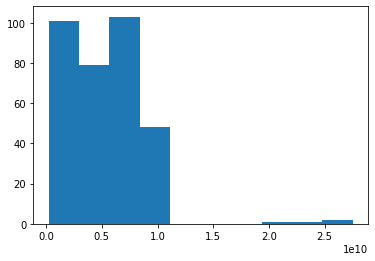

In [20]:
plt.hist(df['size'])

In [21]:
# convert size to MB for easier reading
df['size_mb'] = [n/1024/1024 for n in df['size']]
df = df[['size_mb']]

In [22]:
df.describe()

,size_mb
count,335.000000
mean,4998.555739
std,3393.347066
min,205.072695
25%,2315.944175
50%,4952.999368
75%,7091.587331
max,26251.847012


# Split the data for analysis

In [23]:
train = df[:'2019-10-17']
validate = df['2019-10-18':'2020-01-15']
test = df['2020-01-16':]


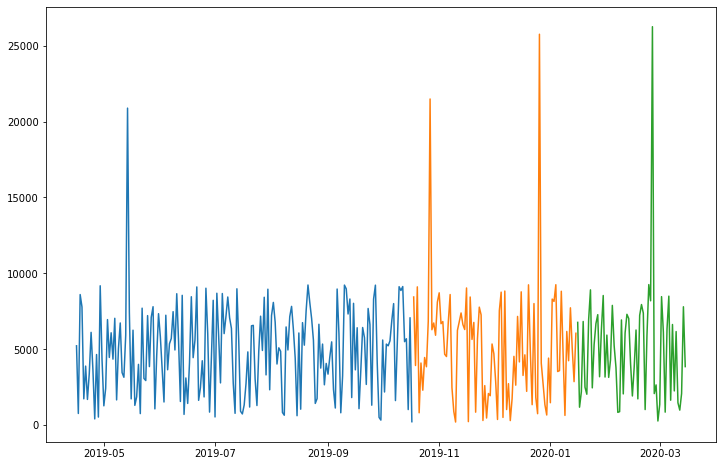

In [24]:
plt.figure(figsize=(12, 8))
plt.plot(train)
plt.plot(validate)
plt.plot(test)
plt.show()

# Simple moving average

In [25]:
# use 1 week rolling average as a short simple moving average (SMA)
sma_short = train.rolling(window=7).mean()
sma_short[:10]

,size_mb
timestamp,
2019-04-16 00:00:00+00:00,NaN
2019-04-17 00:00:00+00:00,NaN
2019-04-18 00:00:00+00:00,NaN
2019-04-19 00:00:00+00:00,NaN
2019-04-20 00:00:00+00:00,NaN
2019-04-21 00:00:00+00:00,NaN
2019-04-22 00:00:00+00:00,4243.204973
2019-04-23 00:00:00+00:00,3982.060231
2019-04-24 00:00:00+00:00,4745.413321


In [26]:
# use 30 day rolling average as long SMA
sma_long = train.rolling(window=30).mean()
sma_long[27:33]

,size_mb
timestamp,
2019-05-13 00:00:00+00:00,NaN
2019-05-14 00:00:00+00:00,NaN
2019-05-15 00:00:00+00:00,4961.788469
2019-05-16 00:00:00+00:00,4845.214955
2019-05-17 00:00:00+00:00,5028.132211
2019-05-18 00:00:00+00:00,4784.815609


Text(0, 0.5, 'Size (MB)')

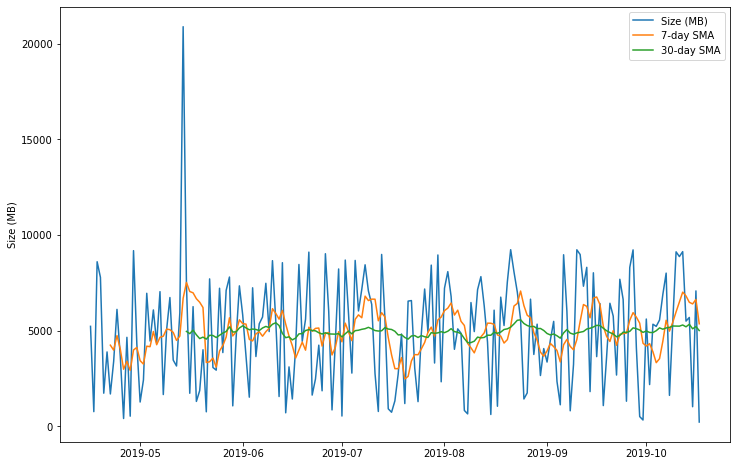

In [27]:
# plot the short and the long averages with size
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(train.index, train, label='Size (MB)')

ax.plot(train.index, sma_short, label = '7-day SMA')

ax.plot(train.index, sma_long, label = '30-day SMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')
# ax.xaxis.(rotate=90)
# ax.xaxis.set_major_formatter(my_datetime_fmt)

# Exponential Moving Average

SMA time series are much less noisy than the time series of the original data points. The challenge with SMA, however, is that the values of SMA lag the original values. This means that changes in the trend are only seen with a delay (lag) of L time units.

Exponential Moving Average (EMA) helps reduce the lag induced by the use of the SMA. It does this by putting more weight on more recent observations, while the SMA weights all observations equally.

In [28]:
# use the ewm function to calculate the 7 day (this is the span) Exponential Moving Average (EMA)
ema_short = train.ewm(span=7).mean()
ema_short.head()

,size_mb
timestamp,
2019-04-16 00:00:00+00:00,5226.592266
2019-04-17 00:00:00+00:00,2679.440056
2019-04-18 00:00:00+00:00,5241.148359
2019-04-19 00:00:00+00:00,6171.969062
2019-04-20 00:00:00+00:00,4717.141470


In [29]:
# and again to get the long span of 30 days
ema_long = train.ewm(span=30).mean()
ema_long.tail()

,size_mb
timestamp,
2019-10-13 00:00:00+00:00,5648.854750
2019-10-14 00:00:00+00:00,5651.601642
2019-10-15 00:00:00+00:00,5353.218240
2019-10-16 00:00:00+00:00,5464.523142
2019-10-17 00:00:00+00:00,5126.588931


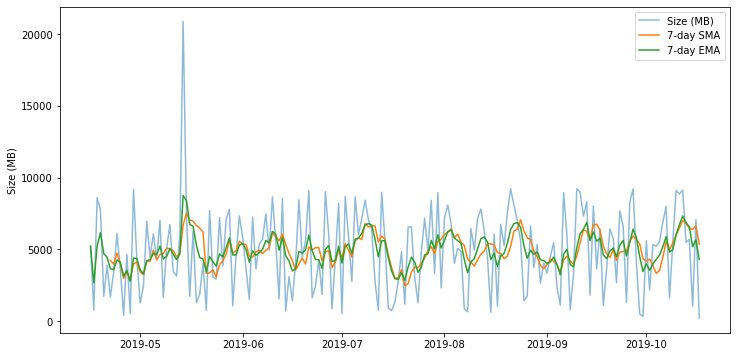

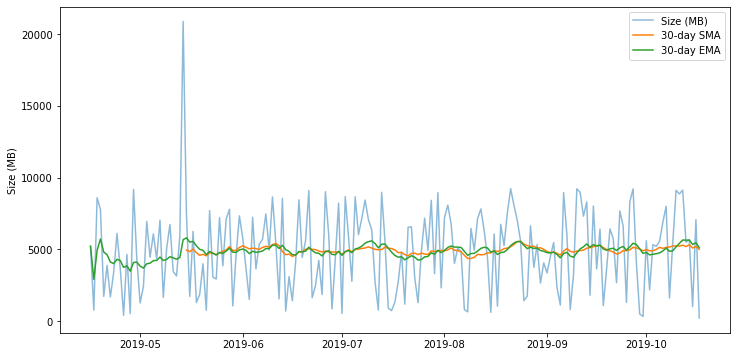

In [30]:
# plot these results
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(train.index, train, label='Size (MB)', alpha=.5)

ax.plot(train.index, sma_short, label = '7-day SMA')
ax.plot(train.index, ema_short, label = '7-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

plt.show()

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(train.index, train, label='Size (MB)', alpha=.5)

ax.plot(train.index, sma_long, label = '30-day SMA')
ax.plot(train.index, ema_long, label = '30-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

plt.show()

# ax.xaxis.(rotate=90)
# ax.xaxis.set_major_formatter(my_datetime_fmt)

comparing the plot of the SMA to the EMA shows that the EMA is generally smoother

# Bollinger Bands and %b

**Bollinger Bands**     
- a volatility indicator and commonly used in stock market trading.
- Made up of 3 lines, the Upper Band (UB), the Lower Band (LB) and the Midband.

Midband
- The Exponential Moving Average
- midband = train.ewm(span=30).mean()

Upper & Lower Band
- UB/LB = Midband +/- stdev * K
- stdev = train.ewm(span=30).std()
- K = the number of standard deviations to go up and down from the EMA
- %b, Percent Bandwidth
    - Shows where the last value sits in relation to the bands
- $\%b = \frac{last-LB}{UB-LB}$
- %b > 1 => point lies above UB
- %b < 0 => point lies below LB
- %b == .5 => point lies on the midband.

Bandwidth
- The width of the bands
- $Bandwidth = \frac{(UB-LB)}{Midband}$

In [32]:
# set the window span
span = 30

# compute midband
midband = train.ewm(span=span).mean()
midband

,size_mb
timestamp,
2019-04-16 00:00:00+00:00,5226.592266
2019-04-17 00:00:00+00:00,2923.542143
2019-04-18 00:00:00+00:00,4944.398965
2019-04-19 00:00:00+00:00,5727.463130
2019-04-20 00:00:00+00:00,4818.764466
...,...
2019-10-13 00:00:00+00:00,5648.854750
2019-10-14 00:00:00+00:00,5651.601642
2019-10-15 00:00:00+00:00,5353.218240


In [33]:
# compute exponential stdev
stdev = train.ewm(span=span).std()
stdev

,size_mb
timestamp,
2019-04-16 00:00:00+00:00,NaN
2019-04-17 00:00:00+00:00,3151.940050
2019-04-18 00:00:00+00:00,3988.694191
2019-04-19 00:00:00+00:00,3521.755279
2019-04-20 00:00:00+00:00,3535.178503
...,...
2019-10-13 00:00:00+00:00,2789.369523
2019-10-14 00:00:00+00:00,2697.910227
2019-10-15 00:00:00+00:00,2853.875505


In [34]:
# compute upper and lower bands
ub = midband + stdev*3
lb = midband - stdev*3

ub

,size_mb
timestamp,
2019-04-16 00:00:00+00:00,NaN
2019-04-17 00:00:00+00:00,12379.362294
2019-04-18 00:00:00+00:00,16910.481538
2019-04-19 00:00:00+00:00,16292.728966
2019-04-20 00:00:00+00:00,15424.299975
...,...
2019-10-13 00:00:00+00:00,14016.963320
2019-10-14 00:00:00+00:00,13745.332322
2019-10-15 00:00:00+00:00,13914.844755


Text(0, 0.5, 'Size (MB)')

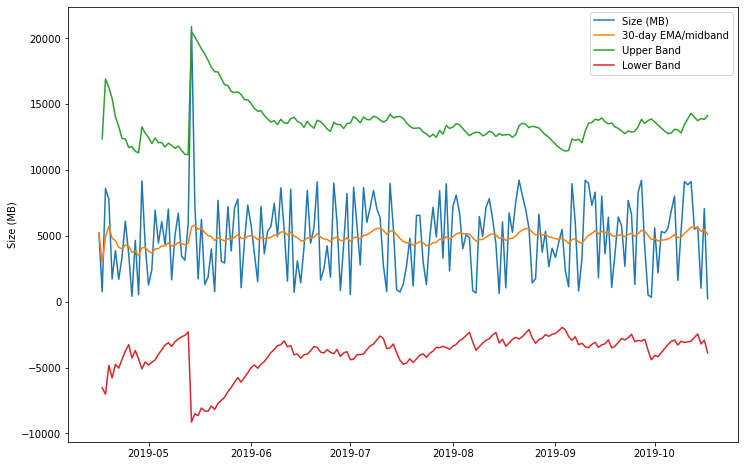

In [35]:
# plot these together
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(train.index, 
        train,
        label='Size (MB)')

ax.plot(train.index, 
        midband, 
        label = '30-day EMA/midband')
ax.plot(train.index, 
        ub, 
        label = 'Upper Band')
ax.plot(train.index, 
        lb, 
        label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

In [36]:
# concat these values to the train dataframe
train = pd.concat([train, midband, ub, lb], axis=1)
train.columns = ['size_mb', 'midband', 'ub', 'lb']
train.tail()

,size_mb,midband,ub,lb
timestamp,,,,
2019-10-13 00:00:00+00:00,5500.400846,5648.854750,14016.963320,-2719.253820
2019-10-14 00:00:00+00:00,5691.431343,5651.601642,13745.332322,-2442.129039
2019-10-15 00:00:00+00:00,1026.682069,5353.218240,13914.844755,-3208.408276
2019-10-16 00:00:00+00:00,7078.436152,5464.523142,13845.738856,-2916.692572
2019-10-17 00:00:00+00:00,226.565814,5126.588931,14133.791810,-3880.613949


In [37]:
# example calculation of %b
(7626 - (-3926.4))/(13060-(-3926))

0.6801130342635111

In [38]:
# create %b feature for train
train['pct_b'] = (train['size_mb'] - train['lb'])/(train['ub'] - train['lb'])

In [39]:
# show all observations where %b is greater than 1 (outside the upperband)
train[train['pct_b']>1]
# for this dataset we can not have negative size so we don't need to look for greater than -1
# which would be outside the lower band

,size_mb,midband,ub,lb,pct_b
timestamp,,,,,
2019-05-14 00:00:00+00:00,20885.558536,5681.14438,20497.057382,-9134.768623,1.013111


there is 1 observation that is outside of the band